# Modélisation des demandes de crédits avec XGBoost

## ************ ATTENTION, LIRE AVANT D'EXECUTER *******************

#### Il est déconseillé d'exécuter ce notebook car le temps de compilation peut être très long compte tenu des procédures d'optimisation utilisées dans ce fichier.

## Chargement des données d'entraînement et de test

In [1]:
import sys
sys.path.insert(0, "/home/cyril/openclassrooms/projets/P7/P7_baudrillart_cyril_V2/custom_functions")
from model_analysis import plot_confusion_matrix, plot_roc_curve

In [2]:
# Import basic ML libraries
import pandas as pd
import numpy as np
from collections import Counter
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
# Scikit-Learn imports
from sklearn.model_selection import (RepeatedStratifiedKFold, cross_validate,
                                     StratifiedKFold, train_test_split,
                                     KFold)
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import (f1_score, recall_score, roc_auc_score, 
                            precision_score, r2_score, accuracy_score, auc)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

# other ML libraries
from imblearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBClassifier

In [4]:
# Chargement des données intégrales imputées
X = pd.read_csv('../data_models/X_top10_imputed.csv', index_col=0)

In [5]:
X.shape

(292062, 12)

In [6]:
# Création de la target
y = X.TARGET
y

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
292057    1.0
292058    1.0
292059    1.0
292060    1.0
292061    1.0
Name: TARGET, Length: 292062, dtype: float64

In [7]:
# Supprimer la target des features
X = X.drop(columns='TARGET')

In [8]:
# Comptage des classes
Counter(y)

Counter({0.0: 268139, 1.0: 23923})

La classe 1 est minoritaire.

In [9]:
# train-test split with stratification on the class we are trying to predict
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)

In [10]:
# Nombre d'observations dans chaque classe du test set
Counter(y_test)

Counter({0.0: 80442, 1.0: 7177})

In [11]:
# Rapport entre les classes
Counter(y_test)[0]/Counter(y_test)[1]

11.208304305420093

In [12]:
Counter(y_train)[0]/Counter(y_train)[1]

11.208467693777619

https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

## XGBoost

https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

On commence tout de suite par un équilibrage des classes

### Undersampling

In [17]:
# Imputation des données manquantes par under sampling et modèle xgboost
steps = [('oversample', RandomUnderSampler(random_state=42)),
         ('model', XGBClassifier())]
# création d'un pipeline imblearn
pipeline = Pipeline(steps=steps)

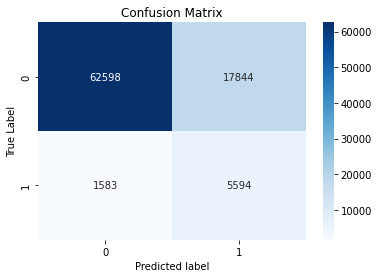

              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87     80442
         1.0       0.24      0.78      0.37      7177

    accuracy                           0.78     87619
   macro avg       0.61      0.78      0.62     87619
weighted avg       0.91      0.78      0.82     87619

ROC AUC Score: 0.78
CPU times: user 21.1 s, sys: 261 ms, total: 21.3 s
Wall time: 1.72 s


In [18]:
%%time
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

Les premiers résultats sont déjà meilleurs que ceux de la régression logistique.

In [ ]:
On peut tenter de rajouter une phase de normalisation des features

In [21]:
# Imputation des données manquantes par under sampling et modèle xgboost
steps = [('oversample', RandomUnderSampler(random_state=42)),
         ('scaler', StandardScaler()),
         ('model', XGBClassifier())]
# création d'un pipeline imblearn
pipeline = Pipeline(steps=steps)

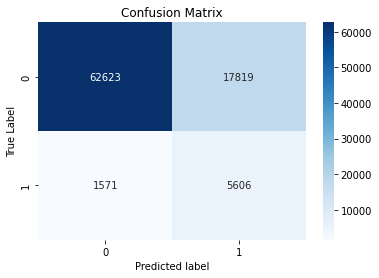

              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87     80442
         1.0       0.24      0.78      0.37      7177

    accuracy                           0.78     87619
   macro avg       0.61      0.78      0.62     87619
weighted avg       0.92      0.78      0.83     87619

ROC AUC Score: 0.78
CPU times: user 20.9 s, sys: 244 ms, total: 21.2 s
Wall time: 1.69 s


In [22]:
%%time
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [ ]:
La normalisation ne modifie pas la performance du modèle.

### Oversampling

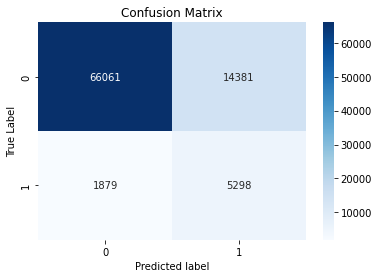

              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89     80442
         1.0       0.27      0.74      0.39      7177

    accuracy                           0.81     87619
   macro avg       0.62      0.78      0.64     87619
weighted avg       0.91      0.81      0.85     87619

ROC AUC Score: 0.78


In [15]:
# Imputation des données manquantes par over sampling et xgboost
steps = [('oversample', RandomOverSampler(random_state=42)),
         ('model', XGBClassifier())]

pipeline = Pipeline(steps=steps)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

Le recall est un peu moins bon qu'avec l'undersampling

### SMOTE sampling

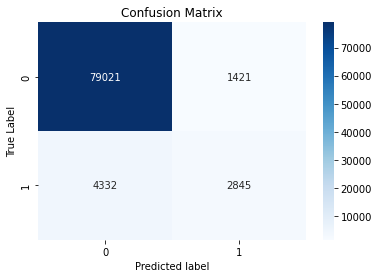

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     80442
         1.0       0.67      0.40      0.50      7177

    accuracy                           0.93     87619
   macro avg       0.81      0.69      0.73     87619
weighted avg       0.93      0.93      0.93     87619

ROC AUC Score: 0.69


In [16]:
# Imputation des données manquantes avec SMOTE et xgboost
oversample_model = SMOTE(sampling_strategy='auto', k_neighbors=5)

steps = [('sampling', oversample_model),
         ('model', XGBClassifier())]

pipeline = Pipeline(steps=steps)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

L'échantillonnage avec SMOTE ne donne pas de bons résultats.

### Utilisation du paramètre 'scale_pos_weight'

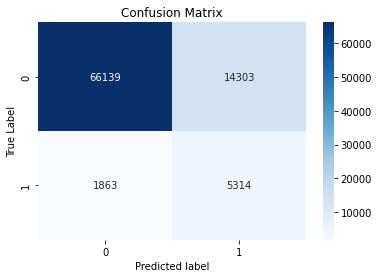

              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89     80442
         1.0       0.27      0.74      0.40      7177

    accuracy                           0.82     87619
   macro avg       0.62      0.78      0.64     87619
weighted avg       0.92      0.82      0.85     87619

ROC AUC Score: 0.78


In [15]:
# Rééquilibrage des classes avec le paramètre xgboost 'scale_pos_weight'
steps = [('model', XGBClassifier(scale_pos_weight=11))]

pipeline = Pipeline(steps=steps)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

Les résultats sont globalement bons. Le recall le plus élevé est obtenu avec une égalisation des classes par under sampling.

## Optimisation des hyperparamètres XGBoost

### Documentation 
Process pour optimisation d'un XGBoost:  
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/  
Autres docs sur le sujet:  
https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook  
https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost/notebook  
https://www.mikulskibartosz.name/xgboost-hyperparameter-tuning-in-python-using-grid-search/  
https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65  

In [52]:
# paramètres de départ
# Copie des paramètres Analytics Vidhya
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

In [53]:
# construction du pipeline imblearn
# mputation des données manquantes par undersampling et xgboost
steps = [('sampling', RandomUnderSampler(random_state=42)),
         ('model', xgb1)]
xgbclassifier1 = Pipeline(steps=steps)

In [54]:
xgbclassifier1['model'].get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 1000,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'nthread': 4,
 'seed': 27}

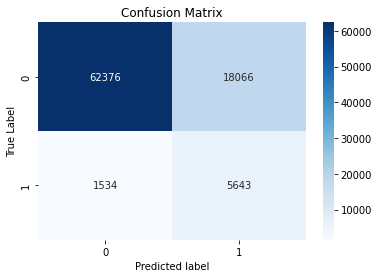

              precision    recall  f1-score   support

         0.0       0.98      0.78      0.86     80442
         1.0       0.24      0.79      0.37      7177

    accuracy                           0.78     87619
   macro avg       0.61      0.78      0.61     87619
weighted avg       0.92      0.78      0.82     87619

ROC AUC Score: 0.78


In [55]:
xgbclassifier1.fit(X_train, y_train)
y_pred = xgbclassifier1.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

### Optimisation des paramètres 'max_depth' et 'min_child_weight'

Ces 2 paramètres ont le plus fort impact sur le modèle

'max depth' -> profondeur maximale de l'arbre. Range 3-10.  
'min_child_weight' -> minimum sum of weights of all observations required in a child. Défaut = 1

In [56]:
# utilisation de la cross validation
cv = StratifiedKFold(n_splits=3)
# define search space
params = {'model__max_depth': range(2, 10, 2),
         'model__min_child_weight':range(1,10,2)
         }
# define search
gsearch1 = RandomizedSearchCV(xgbclassifier1,
                            params,
                            scoring='recall',
                            cv=cv,
                            verbose=3,
                            n_jobs=-1)

In [57]:
%%time
gsearch1.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 21.3 s, sys: 311 ms, total: 21.6 s
Wall time: 24min 46s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('sampling',
                                              RandomUnderSampler(random_state=42)),
                                             ('model',
                                              XGBClassifier(base_score=0.5,
                                                            booster='gbtree',
                                                            callbacks=None,
                                                            colsample_bylevel=1,
                                                            colsample_bynode=1,
                                                            colsample_bytree=0.8,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric...
                                                            max_cat_to_onehot=4,
                                                            max_delta_step=0,
                                                            max_depth=5,
                                                            max_leaves=0,
                                                            min_child_weight=1,
                                                            missing=nan,
                                                            monotone_constraints='()',
                                                            n_estimators=1000,
                                                            n_jobs=4, nthread=4,
                                                            num_parallel_tree=1,
                                                            predictor='auto',
                                                            random_state=27,
                                                            reg_alpha=0, ...))]),
                   n_jobs=-1,
                   param_distributions={'model__max_depth': range(2, 10, 2),
                                        'model__min_child_weight': range(1, 10, 2)},
                   scoring='recall', verbose=3)

In [58]:
# Affichage des paramètres optimisés
gsearch1.best_params_

{'model__min_child_weight': 3, 'model__max_depth': 2}

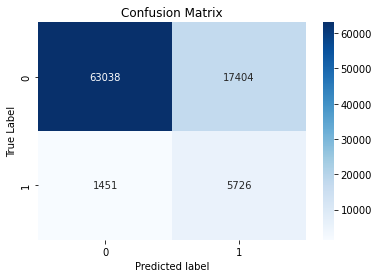

              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87     80442
         1.0       0.25      0.80      0.38      7177

    accuracy                           0.78     87619
   macro avg       0.61      0.79      0.62     87619
weighted avg       0.92      0.78      0.83     87619

ROC AUC Score: 0.79
CPU times: user 1.39 s, sys: 1.51 s, total: 2.9 s
Wall time: 494 ms


In [59]:
%%time
y_pred = gsearch1.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [72]:
gsearch1.best_estimator_[-1]

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=27, reg_alpha=0, ...)

### Entrainement du modèle sélectionné avec Gridsearch

In [73]:
# paramètres de départ
# Copie des paramètres Analytics Vidhya
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

In [74]:
# Imputation des données manquantes et randomforest
steps = [('sampling', RandomUnderSampler(random_state=42)),
         ('model', xgb2)]
xgbclassifier2 = Pipeline(steps=steps)

In [78]:
param_test2 = {
 'model__max_depth':[2, 3, 4],
 'model__min_child_weight':[2, 3, 4]
}

In [79]:
gsearch2 = GridSearchCV(estimator = xgbclassifier2, 
                        param_grid = param_test2,
                        scoring='recall',
                        n_jobs=-1,
                        verbose=3,
                        cv=cv)

In [80]:
gsearch2.fit(X_train.values, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('sampling',
                                        RandomUnderSampler(random_state=42)),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=0.8,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=No...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=2,
                                                      max_leaves=None,
                                                      min_child_weight=3,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=1000,
                                                      n_jobs=None, nthread=4,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None,
                                                      reg_alpha=None, ...))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [2, 3, 4],
                         'model__min_child_weight': [2, 3, 4]},
             scoring='recall', verbose=3)

In [85]:
gsearch2.best_params_

{'model__max_depth': 2, 'model__min_child_weight': 3}

In [82]:
gsearch2.best_estimator_[-1]

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=27, reg_alpha=0, ...)

In [83]:
gsearch2

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('sampling',
                                        RandomUnderSampler(random_state=42)),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=0.8,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=No...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=2,
                                                      max_leaves=None,
                                                      min_child_weight=3,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=1000,
                                                      n_jobs=None, nthread=4,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None,
                                                      reg_alpha=None, ...))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [2, 3, 4],
                         'model__min_child_weight': [2, 3, 4]},
             scoring='recall', verbose=3)

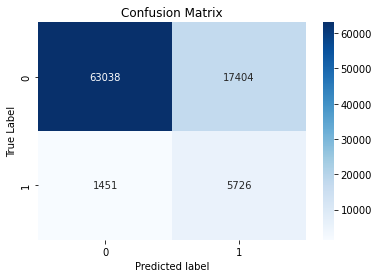

              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87     80442
         1.0       0.25      0.80      0.38      7177

    accuracy                           0.78     87619
   macro avg       0.61      0.79      0.62     87619
weighted avg       0.92      0.78      0.83     87619

ROC AUC Score: 0.79
CPU times: user 744 ms, sys: 188 ms, total: 933 ms
Wall time: 381 ms


In [86]:
%%time
y_pred = gsearch2.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

### Optimisation du paramètre gamma

In [103]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

In [104]:
# Imputation des données manquantes et randomforest
steps = [('sampling', RandomUnderSampler(random_state=42)),
         ('model', xgb3)]
xgbclassifier3 = Pipeline(steps=steps)

In [105]:
param3 = {
        'model__gamma':[i/10.0 for i in range(0,5)]
}

In [106]:
param3

{'model__gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}

In [107]:
gsearch3 = GridSearchCV(estimator = xgbclassifier3,
                        param_grid = param3,
                        scoring='recall',
                        n_jobs=-1,
                        verbose=3,
                        cv=cv)

In [108]:
%%time
gsearch3.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: user 19 s, sys: 350 ms, total: 19.4 s
Wall time: 4min 46s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('sampling',
                                        RandomUnderSampler(random_state=42)),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=0.8,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=No...
                                                      learning_rate=0.1,
                                                      max_bin=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=2,
                                                      max_leaves=None,
                                                      min_child_weight=3,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=1000,
                                                      n_jobs=None, nthread=4,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None,
                                                      reg_alpha=None, ...))]),
             n_jobs=-1, param_grid={'model__gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             scoring='recall', verbose=3)

In [109]:
gsearch3.best_params_

{'model__gamma': 0.0}

In [110]:
gsearch3

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('sampling',
                                        RandomUnderSampler(random_state=42)),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=0.8,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=No...
                                                      learning_rate=0.1,
                                                      max_bin=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=2,
                                                      max_leaves=None,
                                                      min_child_weight=3,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=1000,
                                                      n_jobs=None, nthread=4,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None,
                                                      reg_alpha=None, ...))]),
             n_jobs=-1, param_grid={'model__gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             scoring='recall', verbose=3)

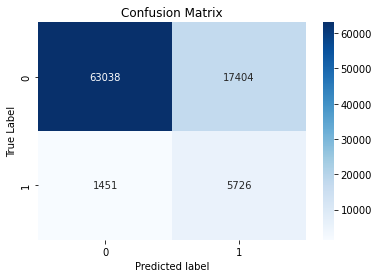

              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87     80442
         1.0       0.25      0.80      0.38      7177

    accuracy                           0.78     87619
   macro avg       0.61      0.79      0.62     87619
weighted avg       0.92      0.78      0.83     87619

ROC AUC Score: 0.79
CPU times: user 1.32 s, sys: 1.46 s, total: 2.78 s
Wall time: 434 ms


In [111]:
%%time
y_pred = gsearch3.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

### Optimisation des paramètres n_estimators, learning_rate et gama

In [113]:
xgb3

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=27, reg_alpha=0, ...)

In [115]:
# Imputation des données manquantes et randomforest
steps = [('sampling', RandomUnderSampler(random_state=42)),
         ('model', xgb3)]
xgbclassifier3 = Pipeline(steps=steps)

In [116]:
# define folds
cv = StratifiedKFold(n_splits=3)
# define search space
params3 = {'model__n_estimators': range(50, 350, 50),
          'model__learning_rate': np.linspace(start = 0.1, stop = 0.8, num = 10)
         }
# define search
gsearch3 = RandomizedSearchCV(xgbclassifier3,
                            params3,
                            scoring='recall',
                            cv=cv,
                            verbose=3,
                            n_jobs=-1)

In [117]:
%%time
gsearch3.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 2.65 s, sys: 124 ms, total: 2.78 s
Wall time: 1min 49s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('sampling',
                                              RandomUnderSampler(random_state=42)),
                                             ('model',
                                              XGBClassifier(base_score=0.5,
                                                            booster='gbtree',
                                                            callbacks=None,
                                                            colsample_bylevel=1,
                                                            colsample_bynode=1,
                                                            colsample_bytree=0.8,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric...
                                                            monotone_constraints='()',
                                                            n_estimators=1000,
                                                            n_jobs=4, nthread=4,
                                                            num_parallel_tree=1,
                                                            predictor='auto',
                                                            random_state=27,
                                                            reg_alpha=0, ...))]),
                   n_jobs=-1,
                   param_distributions={'model__learning_rate': array([0.1       , 0.17777778, 0.25555556, 0.33333333, 0.41111111,
       0.48888889, 0.56666667, 0.64444444, 0.72222222, 0.8       ]),
                                        'model__n_estimators': range(50, 350, 50)},
                   scoring='recall', verbose=3)

In [118]:
%%time
gsearch3.best_params_

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.15 µs


{'model__n_estimators': 100, 'model__learning_rate': 0.25555555555555554}

In [119]:
gsearch3.best_estimator_

Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0.0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.25555555555555554, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=2, max_leaves=0, min_child_weight=3,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=4, nthread=4,
                               num_parallel_tree=1, predictor='auto',
                               random_state=27, reg_alpha=0, ...))])

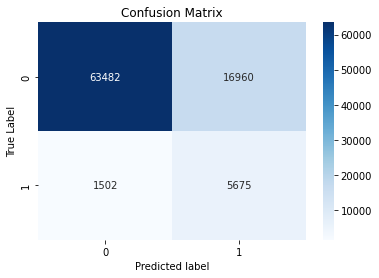

              precision    recall  f1-score   support

         0.0       0.98      0.79      0.87     80442
         1.0       0.25      0.79      0.38      7177

    accuracy                           0.79     87619
   macro avg       0.61      0.79      0.63     87619
weighted avg       0.92      0.79      0.83     87619

ROC AUC Score: 0.79


In [120]:
y_pred = gsearch3.predict(X_test)
plot_confusion_matrix(y_test, y_pred)

Il semble que le modèle a du mal à aller au-delà de 0.80 en recall et score AUC. On va donc arrêter l'optimisation des paramètres à ce stade.

# Recherche du seuil optimal du meilleur modèle XGBoost

In [121]:
# Calcul des probabilités d'appartenir à la classe 1
y_scores = gsearch2.predict_proba(X_test)[:, 1]

0.8857327581678038


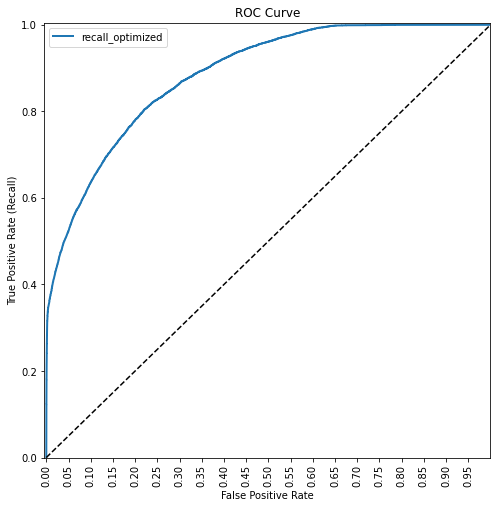

In [122]:
# Courbe ROC associée au modèle Random FOrest
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [123]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (auc_thresholds[ix], gmeans[ix]))

Best Threshold=0.495461, G-Mean=0.792


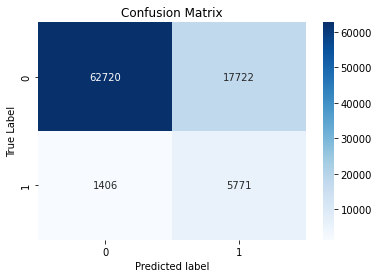

              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87     80442
         1.0       0.25      0.80      0.38      7177

    accuracy                           0.78     87619
   macro avg       0.61      0.79      0.62     87619
weighted avg       0.92      0.78      0.83     87619

ROC AUC Score: 0.79


In [124]:
threshold = 0.4955
y_pred2 = (gsearch2.predict_proba(X_test)[:, 1] > threshold).astype('float')
plot_confusion_matrix(y_test, y_pred2)

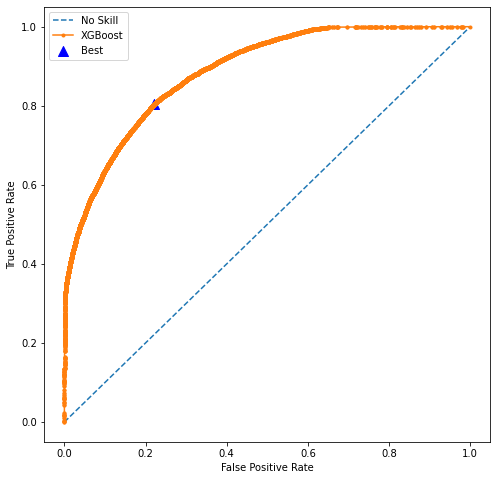

In [125]:
# plot the roc curve for the model
plt.figure(figsize=(8,8))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='XGBoost')
plt.scatter(fpr[ix], tpr[ix], marker='^', color='blue', label='Best', s=100)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

### sauvegarde du modèle final

In [5]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

Afin d'éviter de sauvegarder un pipeline, on va entrainer le modèle avec des données équilibrées. Voir notebook 6.

In [6]:
# Chargement des données équilibrées
X_train_imputed = pd.read_csv('../data_models/X_train_imputed.csv', index_col=0)

In [7]:
X_train_imputed.head()

,EXT_SOURCE_3,EXT_SOURCE_2,PREV_DAYS_DECISION_MIN,CODE_GENDER,DAYS_EMPLOYED,PREV_APP_CREDIT_PERC_MIN,INSTAL_DPD_MAX,AMT_CREDIT,DAYS_BIRTH,FLAG_OWN_CAR,NAME_EDUCATION_TYPE_Higher_education,TARGET
0,0.547810,0.464989,2467.0,1.0,1161.0,1.026477,25.0,700830.0,15920.0,0.0,0.0,0.0
1,0.684828,0.284672,617.0,0.0,6830.0,1.000000,0.0,1042560.0,14970.0,1.0,1.0,0.0
2,0.340906,0.682258,1307.0,1.0,1045.0,0.834716,6.0,112500.0,10975.0,0.0,1.0,0.0
3,0.778904,0.750705,2823.0,0.0,8100.0,0.000000,80.0,808650.0,14948.0,1.0,0.0,0.0
4,0.713631,0.419807,422.0,1.0,751.0,0.825616,0.0,509602.5,11680.0,0.0,0.0,0.0


In [8]:
# création du vecteur avec la target
y_train_imputed = X_train_imputed.TARGET
X_train_imputed = X_train_imputed.drop(columns=['TARGET'])

In [9]:
# vérification de l'équilbre des classes
Counter(y_train_imputed)

Counter({0.0: 16792, 1.0: 16700})

In [10]:
xgb3.fit(X_train_imputed, y_train_imputed)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=27, reg_alpha=0, ...)

In [11]:
# Create du fichier Pickle
pickle_out = open("../data_models/classifier_xgb_best.pkl", "wb")
pickle.dump(xgb3, pickle_out)
pickle_out.close()